# Lab 03 : GAN with CNN - solution

The goal is to implement a GAN architecture with CNNs to generate new MNIST images.</br>

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_codes/codes/labs_lecture15/lab03_GAN_CNN'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/GAN/new_codes/labs_lecture15/lab03_GAN_CNN
/content/gdrive/My Drive/GAN/new_codes/labs_lecture15/lab03_GAN_CNN


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time

### GPU is required to train GAN

In [3]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [4]:
# Libraries
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings

### MNIST dataset 

In [5]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
print(train_data.size())

torch.Size([60000, 28, 28])


### Network architecture

In [6]:
# Global constants
# n : nb of pixels along each spatial dimension
# dz : latent dimension
# d : hidden dimension
# b : batch size
n = train_data.size(1)
dz = n
d = 128
b = 64


In [7]:
# Define the generator and discriminator networks
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        # COMPLETE HERE
        self.linear1 = nn.Linear(dz, d, bias=True) 
        self.bn1 = nn.BatchNorm1d(d)
        self.linear2 = nn.Linear(d, d*(n//4)**2, bias=True)
        self.bn2 = nn.BatchNorm1d(d*(n//4)*(n//4))
        self.tconv1 = nn.ConvTranspose2d(d, d, kernel_size=4, padding=1, stride=2) #  d x 7 x 7 --> d x 14 x 14 
        self.bn3 = nn.BatchNorm2d(d)
        self.tconv2 = nn.ConvTranspose2d(d,  1, kernel_size=4, padding=1, stride=2) #  d x 14 x 14 --> d x 28 x 28
    def forward(self, z): 
        # COMPLETE HERE
        h = self.linear1(z) # [b, d]
        h = self.bn1(h)
        h = torch.relu(h)
        h = self.linear2(h) # [b, d* (n//4)**2]
        h = self.bn2(h)
        h = torch.relu(h)
        h = h.view(-1, d, n//4, n//4) # [b, d, n//4, n//4]
        h = self.tconv1(h) # [b, d, n//2, n//2]
        h = self.bn3(h)
        h = torch.relu(h)
        h = self.tconv2(h) # [b, 1, n, n], nb colors = 1
        #g_z = torch.tanh(h) # in general [-1,1]
        g_z = torch.sigmoid(h) # for mnist [0,1]
        return g_z

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        # COMPLETE HERE
        self.conv1 = nn.Conv2d(1, d, kernel_size=4, padding=1, stride=2) #  1 x 28 x 28 --> d x 14 x 14
        self.bn1 = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d, kernel_size=4, padding=1, stride=2) #  d x 14 x 14 --> d x 7 x 7
        self.bn2 = nn.BatchNorm2d(d)
        self.linear1 = nn.Linear(d*(n//4)**2, d, bias=True)
        self.bn3 = nn.BatchNorm1d(d)
        self.linear2 = nn.Linear(d, 1, bias=True)
    def forward(self, h): 
        # COMPLETE HERE
        h = self.conv1(h) # [b, d, n//2, n//2]  
        h = self.bn1(h)
        h = torch.relu(h)
        h = self.conv2(h) # [b, d, n//4, n//4] 
        h = self.bn2(h)
        h = torch.relu(h)
        h = h.view(-1, d* (n//4)**2) # [b, d* (n//4)**2]
        h = self.linear1(h) # [b, d]
        h = self.bn3(h)
        h = torch.relu(h)
        h = self.linear2(h) # [b, 1]
        d_h = torch.sigmoid(h)
        return d_h

# Instantiate the network
net_g = generator()
net_g = net_g.to(device)
print(net_g)
utils.display_num_param(net_g) 
net_d = discriminator()
net_d = net_d.to(device)
print(net_d)
utils.display_num_param(net_d) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer_g = torch.optim.Adam(net_g.parameters(), lr=init_lr)
optimizer_d = torch.optim.Adam(net_d.parameters(), lr=init_lr)

b = 10
idx = torch.LongTensor(b).random_(0,60000)
x_real = train_data[idx,:,:].view(b,-1).to(device) # [b, n**2]
print(x_real.size())

z = torch.rand(b, dz).to(device) # [b, dz]
print(z.size())

p_one = torch.ones(b, 1).to(device)
p_zero = torch.zeros(b, 1).to(device)

# update g
optimizer_g.zero_grad()
x_fake = net_g(z) # [b, 1, n, n]
p_fake = net_d(x_fake) # [b, 1]
print(x_fake.size(), p_fake.size())
loss_fake = nn.BCELoss()(p_fake, p_one)
loss = loss_fake
loss.backward()
optimizer_g.step()

# update d
optimizer_d.zero_grad()
x_fake = net_g(z) # [b, 1, n, n]
p_fake = net_d(x_fake) # [b, 1]
p_real = net_d(x_real.view(-1,n,n).unsqueeze(1)) # [b, 1]
print(x_fake.size(), p_fake.size(), p_real.size())
loss_real = nn.BCELoss()(p_real, p_one)
loss_fake = nn.BCELoss()(p_fake, p_zero)
loss = loss_real + loss_fake
loss.backward()
optimizer_d.step()


generator(
  (linear1): Linear(in_features=28, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=6272, bias=True)
  (bn2): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
There are 1090177 (1.09 million) parameters in this neural network
discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

generator(
  (linear1): Linear(in_features=28, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=6272, bias=True)
  (bn2): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
There are 1090177 (1.09 million) parameters in this neural network
discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

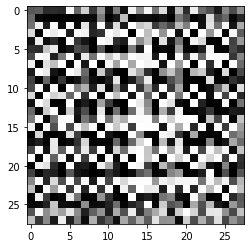

epoch= 1 	 time= 0.1077828327814738 min 	 lr= 0.0002 	 loss_d= 0.8972067648172378 	 loss_g= 1.1767645925283432
epoch= 2 	 time= 0.15982104937235514 min 	 lr= 0.0002 	 loss_d= 0.9125587025284767 	 loss_g= 1.1991437661647797
epoch= 3 	 time= 0.21194043556849163 min 	 lr= 0.0002 	 loss_d= 0.8575250715017319 	 loss_g= 1.2885684478282928
epoch= 4 	 time= 0.2639947017033895 min 	 lr= 0.0002 	 loss_d= 0.7719116526842117 	 loss_g= 1.4162953078746796
epoch= 5 	 time= 0.32222868998845416 min 	 lr= 0.0002 	 loss_d= 0.7152805444598198 	 loss_g= 1.5185093009471893


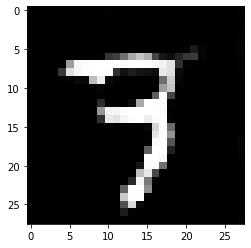

epoch= 6 	 time= 0.37605686982472736 min 	 lr= 0.0002 	 loss_d= 0.6605070811510086 	 loss_g= 1.6130530577898026
epoch= 7 	 time= 0.4282191356023153 min 	 lr= 0.0002 	 loss_d= 0.6607261957228183 	 loss_g= 1.6731194388866424
epoch= 8 	 time= 0.48025284210840863 min 	 lr= 0.0002 	 loss_d= 0.6466920985281468 	 loss_g= 1.7025327652692794
epoch= 9 	 time= 0.5323261539141337 min 	 lr= 0.0002 	 loss_d= 0.6550241462886334 	 loss_g= 1.7398429971933365
epoch= 10 	 time= 0.5842574954032898 min 	 lr= 0.0002 	 loss_d= 0.6447554282844067 	 loss_g= 1.7535778260231019


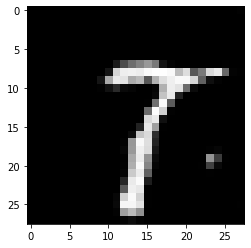

epoch= 11 	 time= 0.6381823937098186 min 	 lr= 0.0002 	 loss_d= 0.6510230131447315 	 loss_g= 1.808929603099823
epoch= 12 	 time= 0.6902155598004659 min 	 lr= 0.0002 	 loss_d= 0.6329134391248226 	 loss_g= 1.8279124742746353
epoch= 13 	 time= 0.7422122319539388 min 	 lr= 0.0002 	 loss_d= 0.6399311423301697 	 loss_g= 1.8458719861507416
epoch= 14 	 time= 0.7942561070124309 min 	 lr= 0.0002 	 loss_d= 0.6261675371229649 	 loss_g= 1.8718379467725754
epoch= 15 	 time= 0.8463772177696228 min 	 lr= 0.0002 	 loss_d= 0.6163508784770966 	 loss_g= 1.874296338558197


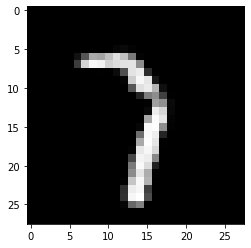

epoch= 16 	 time= 0.9003219723701477 min 	 lr= 0.0002 	 loss_d= 0.6015260328352451 	 loss_g= 1.9446789753437042
epoch= 17 	 time= 0.9525346000989278 min 	 lr= 0.0002 	 loss_d= 0.598215711414814 	 loss_g= 1.9710522907972337
epoch= 18 	 time= 1.0047351360321044 min 	 lr= 0.0002 	 loss_d= 0.6098818853497505 	 loss_g= 1.9532477408647537
epoch= 19 	 time= 1.0569841345151265 min 	 lr= 0.0002 	 loss_d= 0.5925193896889687 	 loss_g= 1.9852549475431442
epoch= 20 	 time= 1.1092123111089072 min 	 lr= 0.0002 	 loss_d= 0.6253887256979942 	 loss_g= 1.9936030077934266


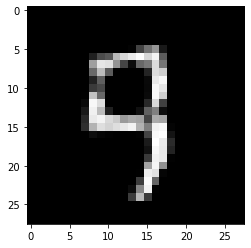

epoch= 21 	 time= 1.1631567200024924 min 	 lr= 0.0002 	 loss_d= 0.5776963087916375 	 loss_g= 2.020030882358551
epoch= 22 	 time= 1.2154012759526571 min 	 lr= 0.0002 	 loss_d= 0.5780013474822044 	 loss_g= 2.0534050410985945
epoch= 23 	 time= 1.2675071318944295 min 	 lr= 0.0002 	 loss_d= 0.5794601519405842 	 loss_g= 2.0629879140853884
epoch= 24 	 time= 1.3197510838508606 min 	 lr= 0.0002 	 loss_d= 0.5698086795210838 	 loss_g= 2.078608469963074
epoch= 25 	 time= 1.371882426738739 min 	 lr= 0.0002 	 loss_d= 0.5907396952807903 	 loss_g= 2.1035217225551603


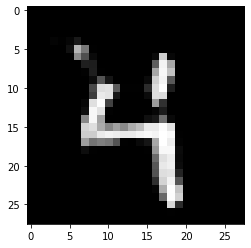

epoch= 26 	 time= 1.4257623076438903 min 	 lr= 0.0002 	 loss_d= 0.5631198535859585 	 loss_g= 2.0844703018665314
epoch= 27 	 time= 1.4779928565025329 min 	 lr= 0.0002 	 loss_d= 0.5626035031676292 	 loss_g= 2.1375408041477204
epoch= 28 	 time= 1.5300642689069113 min 	 lr= 0.0002 	 loss_d= 0.5257516445219517 	 loss_g= 2.1997578746080397
epoch= 29 	 time= 1.5821243882179261 min 	 lr= 0.0002 	 loss_d= 0.549364486783743 	 loss_g= 2.179373281598091
epoch= 30 	 time= 1.6341771046320597 min 	 lr= 0.0002 	 loss_d= 0.5431401713192463 	 loss_g= 2.2146336740255355


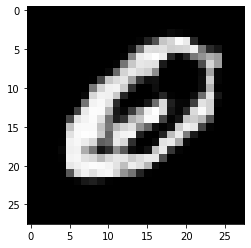

epoch= 31 	 time= 1.6881714900334677 min 	 lr= 0.0002 	 loss_d= 0.5382858350872993 	 loss_g= 2.21373419880867
epoch= 32 	 time= 1.7403740564982095 min 	 lr= 0.0002 	 loss_d= 0.5375709393620491 	 loss_g= 2.2639694952964784
epoch= 33 	 time= 1.7923790733019511 min 	 lr= 0.0002 	 loss_d= 0.5298744238913059 	 loss_g= 2.2500028437376023
epoch= 34 	 time= 1.844487988948822 min 	 lr= 0.0002 	 loss_d= 0.5282753090560436 	 loss_g= 2.2833366060256957
epoch= 35 	 time= 1.8965334177017212 min 	 lr= 0.0002 	 loss_d= 0.5149408113956452 	 loss_g= 2.305514519810677


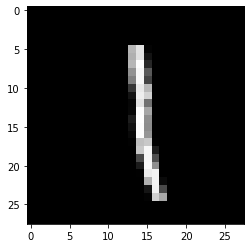

epoch= 36 	 time= 1.9501954873402914 min 	 lr= 0.0002 	 loss_d= 0.4975234653055668 	 loss_g= 2.349395627975464
epoch= 37 	 time= 2.0021927396456403 min 	 lr= 0.0002 	 loss_d= 0.5239403305947781 	 loss_g= 2.360627703666687
epoch= 38 	 time= 2.054323124885559 min 	 lr= 0.0002 	 loss_d= 0.48421584770083426 	 loss_g= 2.37273538172245
epoch= 39 	 time= 2.1063846349716187 min 	 lr= 0.0002 	 loss_d= 0.5069941778481006 	 loss_g= 2.4203571039438248
epoch= 40 	 time= 2.1585026303927104 min 	 lr= 0.0002 	 loss_d= 0.5056423646211624 	 loss_g= 2.399524033665657


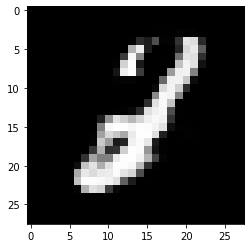

epoch= 41 	 time= 2.2124030868212383 min 	 lr= 0.0002 	 loss_d= 0.48258731901645663 	 loss_g= 2.4555173432826995
epoch= 42 	 time= 2.2644806543986005 min 	 lr= 0.0002 	 loss_d= 0.4739704978466034 	 loss_g= 2.4544366139173506
epoch= 43 	 time= 2.3165982445081075 min 	 lr= 0.0002 	 loss_d= 0.518805000782013 	 loss_g= 2.4736405450105665
epoch= 44 	 time= 2.368631072839101 min 	 lr= 0.0002 	 loss_d= 0.4841741308569908 	 loss_g= 2.4579359114170076
epoch= 45 	 time= 2.4207484404246014 min 	 lr= 0.0002 	 loss_d= 0.46360395424067974 	 loss_g= 2.5176820260286332


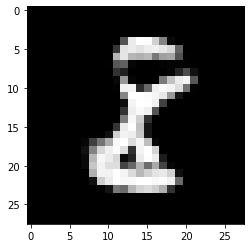

epoch= 46 	 time= 2.4746485630671184 min 	 lr= 0.0002 	 loss_d= 0.4463315173983574 	 loss_g= 2.538931606411934
epoch= 47 	 time= 2.526717034975688 min 	 lr= 0.0002 	 loss_d= 0.504648145288229 	 loss_g= 2.529345006942749
epoch= 48 	 time= 2.5787526528040567 min 	 lr= 0.0002 	 loss_d= 0.4812618370354176 	 loss_g= 2.5271785992383955
epoch= 49 	 time= 2.6308477759361266 min 	 lr= 0.0002 	 loss_d= 0.46167097598314283 	 loss_g= 2.543616372346878


In [8]:
# Training loop
net_g = generator()
net_g = net_g.to(device)
print(net_g)
utils.display_num_param(net_g) 
net_d = discriminator()
net_d = net_d.to(device)
print(net_d)
utils.display_num_param(net_d) 

# Optimizer
init_lr = 0.0002
optimizer_g = torch.optim.Adam(net_g.parameters(), lr=init_lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(net_d.parameters(), lr=init_lr, betas=(0.5, 0.999))

nb_batch = 200 # GPU # Nb of mini-batches per epoch
b = 64  # Batch size

p_one = torch.ones(b, 1).to(device)
p_zero = torch.zeros(b, 1).to(device)

start=time.time()
for epoch in range(50):

    running_loss_d = 0.0
    running_loss_g = 0.0
    num_batches = 0
    
    for _ in range(nb_batch):
        
        # FORWARD AND BACKWARD PASS
        idx = torch.LongTensor(b).random_(0,60000)
        x_real = train_data[idx,:,:].view(b,-1).to(device) # [b, n**2]
        z = torch.rand(b, dz).to(device) # Uniform distribution # [b, dz]
        
        # update d
        optimizer_d.zero_grad()
        x_fake = net_g(z) # [b, 1, n, n]
        p_fake = net_d(x_fake) # [b, 1]
        p_real = net_d(x_real.view(-1,n,n).unsqueeze(1)) # [b, 1]
        loss_real = nn.BCELoss()(p_real, p_one)
        loss_fake = nn.BCELoss()(p_fake, p_zero)
        loss = loss_real + loss_fake
        loss_d = loss.detach().item()
        loss.backward()
        optimizer_d.step()
        
        # update g
        optimizer_g.zero_grad()
        x_fake = net_g(z) # [b, 1, n, n]
        p_fake = net_d(x_fake) # [b, 1]
        loss_fake = nn.BCELoss()(p_fake, p_one)
        loss = loss_fake
        loss_g = loss.detach().item()
        loss.backward()
        optimizer_g.step()

        # COMPUTE STATS
        running_loss_d += loss_d
        running_loss_g += loss_g
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss_d = running_loss_d/ num_batches
    total_loss_g = running_loss_g/ num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss_d=', total_loss_d ,'\t loss_g=', total_loss_g )

    if not epoch%5:
        plt.imshow(x_fake.view(b,n,n).detach().cpu()[0,:,:], cmap='gray'); plt.show() 
    

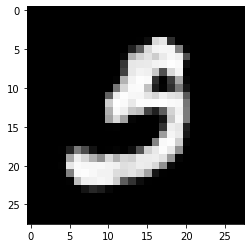

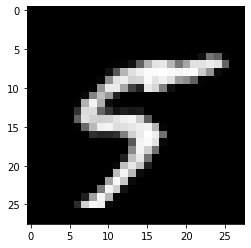

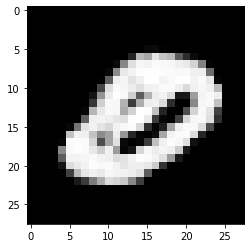

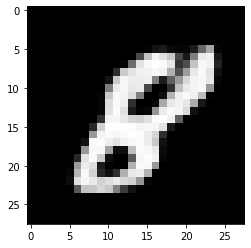

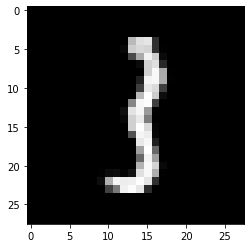

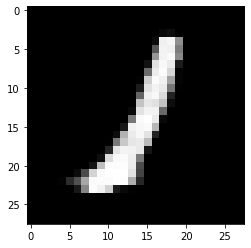

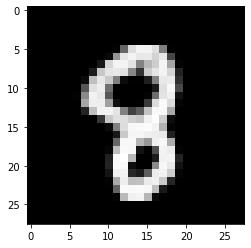

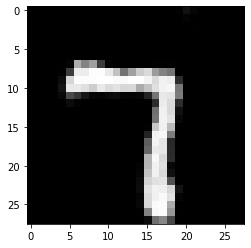

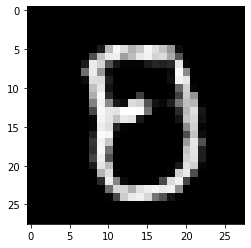

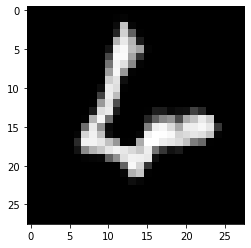

In [9]:
# Generate a few images
b = 10
z = torch.rand(b, dz) # Uniform distribution 
z = z.to(device)
x_new = net_g(z).view(b,n,n).detach().cpu()
for k in range(b):
    plt.imshow(x_new[k,:,:], cmap='gray'); plt.show() 
  